In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

Для начала, необходимо загрузить данные о заказах:

In [3]:
orders = pd.read_csv('orders.csv')
orders

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09-07,Standard,DK-13375,377.970
1,100090,2014-07-08,Standard,EB-13705,699.192
2,100293,2014-03-14,Standard,NF-18475,91.056
3,100328,2014-01-28,Standard,JC-15340,3.928
4,100363,2014-04-08,Standard,JM-15655,21.376
...,...,...,...,...,...
5004,168802,2017-11-03,Standard,JO-15145,18.368
5005,169320,2017-07-23,Second,LH-16900,171.430
5006,169488,2017-09-07,First,AA-10375,56.860
5007,169502,2017-08-28,Standard,MG-17650,113.410


Для удобства создадим новую колонку order_month, отражающую год и месяц заказа:

In [4]:
orders['order_date'] = pd.to_datetime(orders['order_date'],infer_datetime_format=True)
orders['order_month'] = orders['order_date'].dt.strftime('%Y-%m')
orders

,id,order_date,ship_mode,customer_id,sales,order_month
0,100006,2014-09-07,Standard,DK-13375,377.970,2014-09
1,100090,2014-07-08,Standard,EB-13705,699.192,2014-07
2,100293,2014-03-14,Standard,NF-18475,91.056,2014-03
3,100328,2014-01-28,Standard,JC-15340,3.928,2014-01
4,100363,2014-04-08,Standard,JM-15655,21.376,2014-04
...,...,...,...,...,...,...
5004,168802,2017-11-03,Standard,JO-15145,18.368,2017-11
5005,169320,2017-07-23,Second,LH-16900,171.430,2017-07
5006,169488,2017-09-07,First,AA-10375,56.860,2017-09
5007,169502,2017-08-28,Standard,MG-17650,113.410,2017-08


Затем необходимо к каждому заказу определить месяц, в который текущий покупатель сделал свой первый заказ. Как и в предыдущих этапах, достаточно просто запустить ячейки:

In [5]:
cohorts = orders.groupby('customer_id',as_index=False)['order_month'].min()
cohorts.rename(columns = {'order_month':'cohort'},inplace=True)

In [6]:
df_merged = pd.merge(orders, cohorts, how='left', on='customer_id')
df_merged

,id,order_date,ship_mode,customer_id,sales,order_month,cohort
0,100006,2014-09-07,Standard,DK-13375,377.970,2014-09,2014-09
1,100090,2014-07-08,Standard,EB-13705,699.192,2014-07,2014-07
2,100293,2014-03-14,Standard,NF-18475,91.056,2014-03,2014-03
3,100328,2014-01-28,Standard,JC-15340,3.928,2014-01,2014-01
4,100363,2014-04-08,Standard,JM-15655,21.376,2014-04,2014-04
...,...,...,...,...,...,...,...
5004,168802,2017-11-03,Standard,JO-15145,18.368,2017-11,2014-01
5005,169320,2017-07-23,Second,LH-16900,171.430,2017-07,2014-08
5006,169488,2017-09-07,First,AA-10375,56.860,2017-09,2014-04
5007,169502,2017-08-28,Standard,MG-17650,113.410,2017-08,2014-08


Далее приведен код, преобразующий наши данные в новую таблицу data, состоящую из продолжительности пользования сервисом и месяца, в который пользователь впервые сделал заказ (когорты):

In [7]:
def cohort_period(df):
    """
    Creates column CohortPeriod
    """
    df['CohortPeriod'] = np.arange(len(df))
    return df

In [8]:
cohorts_group = df_merged.groupby(['cohort', 'order_month']).agg({'customer_id': pd.Series.nunique})
cohorts_group.rename(columns={'customer_id': 'TotalUsers'}, inplace=True)
cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['cohort', 'CohortPeriod'], inplace=True) 
cohort_group_size = cohorts_group['TotalUsers'].groupby(level=0).first()
user_retention = cohorts_group['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)

Чтобы взять нужные данные из таблицы, в квадратных скобках необходимо указать срезы, по которым будет браться данные из таблицы. В первых скобках необходимо указать период, который мы рассматриваем - это продолжительность в месяцах после первого заказа, во вторых скобках - соответствующие когорты, которые мы хотим рассмотреть. В качестве периода обычно лучше указывать первые несколько месяцев, поскольку именно они нам и интересны, поэтому значение в скобках равно ':12'. Для когорт нам интересно рассмотреть последние n месяцев, т.к. нам интересна динамика за последние несколько лет - отсюда и значение '-20:-1'.

In [9]:
# первый срез - период, второй - когорта
data = user_retention[:12].T[-20:-1]
data

CohortPeriod,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2015-11,1.0,0.100000,0.100000,0.100000,0.100000,0.200000,0.100000,0.100000,0.200000,0.100000,0.200000,0.200000
2015-12,1.0,0.076923,0.076923,0.153846,0.153846,0.230769,0.076923,0.230769,0.153846,0.153846,0.076923,0.076923
2016-01,1.0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.333333,0.333333
2016-02,1.0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,NaN,NaN,NaN,NaN
2016-03,1.0,0.500000,0.500000,0.166667,0.166667,0.166667,0.166667,0.500000,0.166667,0.166667,0.333333,0.333333
2016-04,1.0,0.285714,0.142857,0.142857,0.571429,0.142857,0.285714,0.142857,0.142857,0.285714,0.285714,0.142857
2016-05,1.0,0.142857,0.285714,0.142857,0.142857,0.285714,0.142857,0.285714,0.142857,0.285714,0.142857,0.142857
2016-06,1.0,0.125000,0.250000,0.375000,0.125000,0.125000,0.125000,0.125000,0.250000,0.250000,0.250000,0.375000
2016-07,1.0,0.500000,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Для удобства визуализируем полученную таблицу - чем темнее цвет, тем хуже retention rate (пустые клетки означают retention rate = 0)

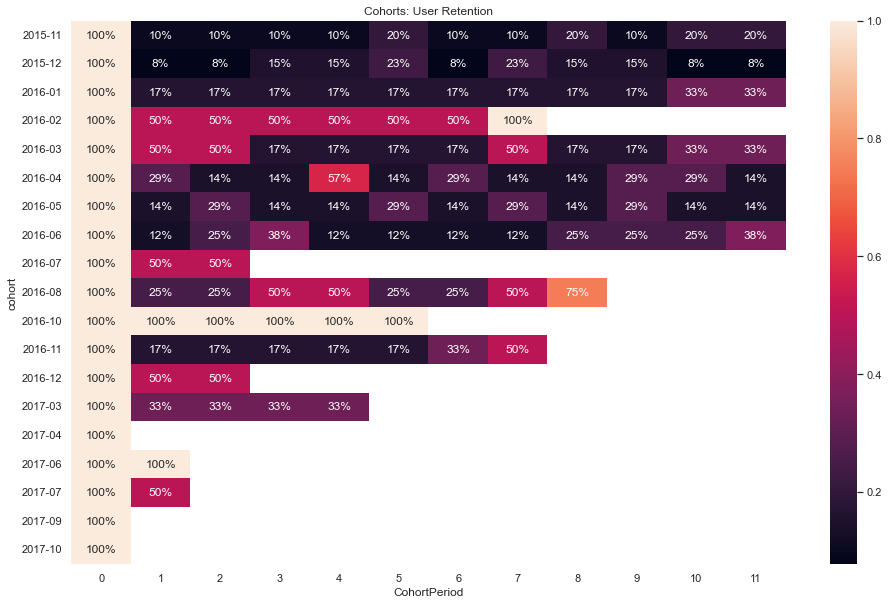

In [10]:
sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(data, mask=data.isnull(), annot=True, fmt='.0%');

Как видно из таблицы, четкой диагонали значений у нижних когорт нет - это значит, процент людей, вернувшихся на нашу площадку, равен 0. Хотя у некоторых месяцев retention rate остается высоким на протяжении нескольких месяцев, в какой-то момент он резко падает до 0. Кроме того, в 16-17 годах отсутствует несколько месяцев - это говорит о том, что людей, впервые пришедших на наш сервис, нет совсем. Это может быть связано с эффектом word of mouth - люди, недовольные доставкой, не советовали пользоваться другим нашими услугами, вследствие чего мы потеряли потенциальным клиентов. 

Для качественного анализа в будущем необходимо смотреть на последние несколько месяцев - в случае улучшения нашего сервиса ячейки будут заметно светлее, чем в предыдущие когорты - кроме того, необходимо наличие четкой диагонали, ведь ее отсутствие говорит о нулевом retention rate.